In [1]:
import io
import os
import platform
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

In [2]:
data=pd.read_csv('chengdu.csv')
dataset=data.iloc[:,-1]
dataset.replace(9999,np.nan,inplace=True)
dataset.replace(-999,np.nan,inplace=True)
for i in range(len(data)):
    if np.isnan(dataset.iat[i]):
        if i==0:
            dataset.iloc[i]=dataset.iat[i+1]
        elif i==len(data)-1:
            dataset.iloc[i]=dataset.iat[i-1]
        else:
            dataset.iloc[i]=np.nanmean([dataset.iat[i-1],dataset.iat[i+1]])

In [3]:
type(dataset)

pandas.core.series.Series

In [4]:
scaler = preprocessing.MinMaxScaler() 
scaled_values = scaler.fit_transform(pd.DataFrame(dataset))
dataset.iloc[:] = np.squeeze(scaled_values)

In [5]:
data_set=np.asarray(dataset,dtype=np.float32)
seq_len=30 + 1
x=len(data_set)-seq_len
sequences = [data_set[t:t+seq_len] for t in range(x)]
seq=torch.FloatTensor(sequences)

In [6]:
split_row=round(0.90*seq.size(0))
x_train_set=seq[:split_row, :-1]
y_train_set=seq[:split_row, -1]
x_valid_set=seq[split_row:, :-1]
y_valid_set=seq[split_row:, -1]

In [7]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=1,dropout=0,bidirectional=False):
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.dropout=dropout
        self.bidirectional=bidirectional
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self,inputs,hidden):
        outputs,hidden=self.lstm(inputs,hidden)
        predictions=self.linear(outputs[-1])
        return predictions,outputs,hidden
    
    def init_hidden(self,batch_size):
        num_directions=2 if self.bidirectional else 1
        hidden = (torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size))
        return hidden

In [8]:
def get_batch(x,y,i,batch_size):
    if x.dim() == 2:
        x = x.unsqueeze(2)
    batch_x = x[(i*batch_size):(i*batch_size)+batch_size, :, :]
    batch_y = y[(i*batch_size):(i*batch_size)+batch_size]

    # Reshape Tensors into (seq_len, batch_size, input_size) format for the LSTM.
    batch_x = batch_x.transpose(0, 1)
    
    return batch_x, batch_y

In [9]:
def train(model,x_train_set,y_train_set,optimizer,batch_size,epoch):
    num_sequences=x_train_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.train()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_train_set, y_train_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y.unsqueeze(1))
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data
        
    print("Epoch {}: Loss = {:.8f}".format(epoch+1, total_loss/num_batches))
    return total_loss/num_batches

In [10]:
def eval(model,x_valid_set,y_valid_set,optimizer,batch_size):
    num_sequences=x_valid_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.eval()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_valid_set, y_valid_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y.unsqueeze(1))
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data

    print("Validation: Loss = {:.8f}".format(total_loss/num_batches))
    return total_loss/num_batches

In [11]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

Training model for 30 epoch
Epoch 1: Loss = 0.02152348
Validation: Loss = 0.00324557
Epoch 2: Loss = 0.00813831
Validation: Loss = 0.00254333
Epoch 3: Loss = 0.00551776
Validation: Loss = 0.00223864
Epoch 4: Loss = 0.00484597
Validation: Loss = 0.00206183
Epoch 5: Loss = 0.00433611
Validation: Loss = 0.00187927
Epoch 6: Loss = 0.00379287
Validation: Loss = 0.00167274
Epoch 7: Loss = 0.00328729
Validation: Loss = 0.00148469
Epoch 8: Loss = 0.00290636
Validation: Loss = 0.00133649
Epoch 9: Loss = 0.00260335
Validation: Loss = 0.00120853
Epoch 10: Loss = 0.00234639
Validation: Loss = 0.00109928
Epoch 11: Loss = 0.00213168
Validation: Loss = 0.00101171
Epoch 12: Loss = 0.00195535
Validation: Loss = 0.00094362
Epoch 13: Loss = 0.00181144
Validation: Loss = 0.00089036
Epoch 14: Loss = 0.00169386
Validation: Loss = 0.00084753
Epoch 15: Loss = 0.00159763
Validation: Loss = 0.00081208
Epoch 16: Loss = 0.00151890
Validation: Loss = 0.00078225
Epoch 17: Loss = 0.00145480
Validation: Loss = 0.0007

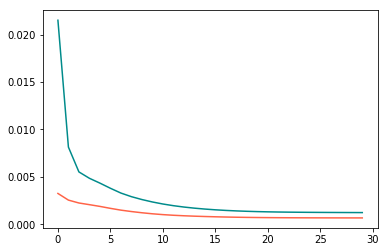

In [12]:
input_size=1
hidden_size=24
num_layers=2
lstm=LSTM(input_size,hidden_size,num_layers)

learning_rate=0.0001
max_grad_norm=5
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=0.00001)

batch_size = 8
num_epochs = 30 #3
# num_sequences = x_train_set.size(0)
# num_batches = num_sequences //batch_size

checkpoint_freq = 10
path = './'

train_losses=[]
valid_losses=[]

print("Training model for {} epoch".format(num_epochs))
for epoch in range(num_epochs):
#     total_loss = 0

    # Shuffle input and target sequences.
    idx = torch.randperm(x_train_set.size(0))
    x = x_train_set[idx]
    y = y_train_set[idx]
    
    train_loss=train(lstm,x_train_set,y_train_set,optimizer,batch_size,epoch)
    valid_loss=eval(lstm,x_valid_set,y_valid_set,optimizer,batch_size)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, lstm, path)
        
# Last checkpoint
save_model(num_epochs, lstm, path)
    
print("\n\n\nOptimization ended.\n")

plt.plot(train_losses, color="darkcyan", label="train")
plt.plot(valid_losses, color="tomato",label="validation")
plt.show()

In [13]:
def predict_one_hour(model,x_valid_set,input_size,num_steps):
    predictions=torch.zeros(num_steps)
    for i, x in enumerate(x_valid_set):
        hidden=model.init_hidden(1)
        y_pred,_,_=model(x.contiguous().view(-1, 1, input_size),hidden)
        predictions[i]=y_pred
    return predictions

In [14]:
one_step_predictions = predict_one_hour(lstm, x_valid_set, input_size, y_valid_set.size(0))

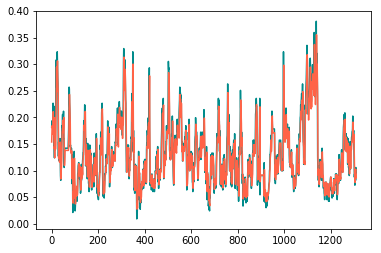

In [15]:
plt.plot(y_valid_set.data.numpy(),color='darkcyan')
plt.plot(one_step_predictions.data.numpy(),color='tomato')
plt.show()